In [1]:
cd ..

/home/m13uz/groningen


In [11]:
import tensorflow as tf
import matplotlib
import numpy as np
import pandas as pd
import json
import os
import itertools
import functools
import data.helpers as helpers
import seaborn as sns
import matplotlib.pyplot as plt
from data.tile_creater import discretiser, grid_translation, get_pixel_lens

In [16]:
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
def plot_slice(tslice, label):
    fig, ax = plt.subplots(1)
    fig.set_size_inches(8,6)
    ax = sns.heatmap(tslice, ax=ax, vmax=1000)
    #ax.set_aspect('equal')
    ax.scatter(label[1], label[0], marker='o', color = 'r', s=50)
    sns.despine()
    fig.tight_layout()
    #fig.savefig('inspecttile', dpi=600)

In [13]:
def get_fnames():
    prefix = 'data/tiles/'
    fnames = [prefix+i for i in os.listdir(prefix)
             if i.split('.')[-1] == 'txt']
    return fnames
def parse_filename(fname):
    no_prefix = fname.strip('data/tiles')
    eventid, seq_id = no_prefix.split('_')
    return eventid, int(seq_id.strip('.txt'))
def get_label(metadata, filename):
    eventid, seqid = parse_filename(filename)
    label = metadata[eventid]
    return label
def _format_label(eventlat,eventlon, eventdepth,
                  eventmag,eventid,topleft,
                  size_x,size_y,numx,numy, nonzeros):
    """
    Args: label is like (53.223, 6.949, 3.0, 0.502994544, 'knmi2018etrn',...)
    (oneevent['eventlat'],oneevent['eventlon']
            ,oneevent['eventdepth'], oneevent['magnitude']
            ,oneevent['eventid'], topleft, sizex, sizey, numx,numy)
    Returns: onehot tile encoding - numpy array
    """
    xy = grid_translation(topleft,eventlat,eventlon)
    plen_x, plen_y = get_pixel_lens(numx, numy, size_x, size_y)
    n,m = discretiser(plen_x,plen_y,xy)
    event_label_matrix = np.zeros((int(numy),int(numx)))
    try:
        event_label_matrix[m,n]=1.0
        event_label_matrix_flatten = event_label_matrix.flatten()
        nonzeroidx = np.nonzero(event_label_matrix_flatten)[0][0]
        return (m,n)#nonzeroidx#event_label_matrix_flatten
    except IndexError:
        print('outside grid')
        #earthquake was outside our grid if index error
        return
def format_frames(metadata,frames):
    """frames is a sequence of (eventid,seqnum,array)"""
    frame_group = list(frames)[0:20]
    label = metadata[frames[0][0]]
    onehot = _format_label(*label)
    tensor_frames = np.dstack([np.loadtxt(frame[2]) 
                               for frame in frame_group])
    return tensor_frames, onehot
def consistent_grouper(n, seq):
    return (i for i in helpers.grouper(n, seq)
            if len(i)==n)

def gen(metadatafile,frames_per_eg, datafilenames):
    with open(metadatafile) as f:
        metadata = json.load(f)
    loaded_files = ((*parse_filename(fname),fname)
                    for fname in datafilenames) #np.loadtxt here in real execution
    sorted_by_event = sorted(loaded_files, key=lambda x:x[0])
    grouped_by_event = itertools.groupby(sorted_by_event, key = lambda x:x[0])
    inorder_by_event = (sorted(g, key = lambda x:x[1]) for k,g in grouped_by_event)
    window_groups_by_event = (helpers.grouper(frames_per_eg, group)
                              for group in inorder_by_event)
    formatted = (format_frames(metadata,framegroup) for framegroup
                 in itertools.chain(*window_groups_by_event))
    ingrid = ((tensor, label) for tensor, label
             in formatted if label)
    return ingrid
    #for idx, row in x.iterrows():
    #    data = np.asarray([row,
    #                       row])
    #    data = np.dstack((data,data, data))
    #    label = y[idx]
    #    yield data, label
def train_input_fn(metadatafile, train_filenames, batch_size=20, repeat=1):
    """An input function for training"""
    # Convert the inputs to a Dataset.
    #dataset = tf.data.Dataset.from_tensor_slices((dict(features), labels))#.map(namer)
    dataset = tf.data.Dataset.from_generator(lambda: gen(metadatafile,500, train_filenames)
                                             ,output_types=(tf.int64, tf.int64)
                                             ,output_shapes = (tf.TensorShape([30,60,20]),
                                                               tf.TensorShape([2]))
                                            )
    # Shuffle, repeat, and batch the examples.
    dataset = dataset.shuffle(100).repeat(repeat).batch(batch_size)
    # Return the dataset.
    iterator = dataset.make_one_shot_iterator()
    d,l = iterator.get_next()
    return {'image':d}, l
def test_input_fn(metadatafile, test_filenames, batch_size=1):
    """An input function for training"""
    # Convert the inputs to a Dataset.
    #dataset = tf.data.Dataset.from_tensor_slices((dict(features), labels))#.map(namer)
    print('testing: ', len(test_filenames))
    dataset = tf.data.Dataset.from_generator(lambda: gen(metadatafile,500, test_filenames)
                                             ,output_types=(tf.int64, tf.int64)
                                             ,output_shapes = (tf.TensorShape([30,60,20]),
                                                               tf.TensorShape([2]))
                                            )
    # Return the dataset.
    dataset=dataset.batch(1)
    iterator = dataset.make_one_shot_iterator()
    d,l = iterator.get_next()
    return {'image':d}, l

def split_traintest(fnames, train_proportion):
    eventgetter = lambda f: parse_filename(f)[0]
    orderedbyevent = sorted(fnames, key = eventgetter) 
    groupedbyevent = [list(g) for k,g in
                      itertools.groupby(orderedbyevent, key = eventgetter)]
    numevents = len(groupedbyevent)
    n_training = int(numevents*train_proportion)
    train, test = groupedbyevent[0:n_training], groupedbyevent[n_training::]
    return list(itertools.chain(*train)), list(itertools.chain(*test))
def specificevent(fnames,event):
    matching = [i for i in fnames if parse_filename(i)[0]==event]
    return matching
def justoneevent(fnames):
    s = sorted(fnames, key = lambda f: parse_filename(f)[0], reverse=True)
    grouped = itertools.groupby(s, key = lambda f: parse_filename(f)[0])
    justone = next((list(g) for k,g in grouped))
    return sorted(justone, key = lambda f: parse_filename(f)[1])

[ 8 20] (1, 30, 60, 20)


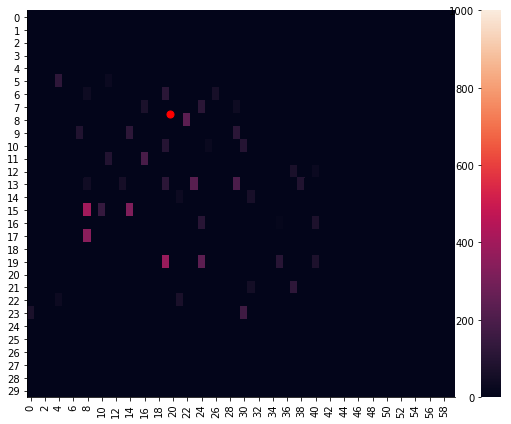

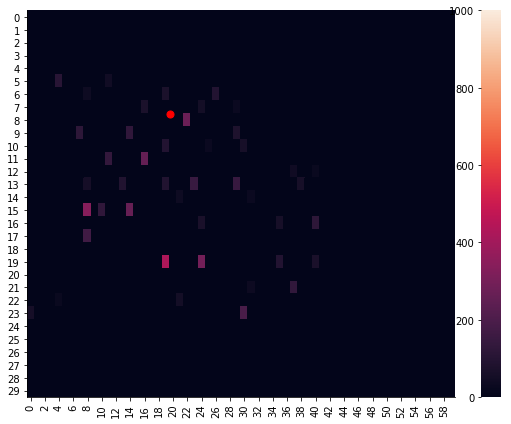

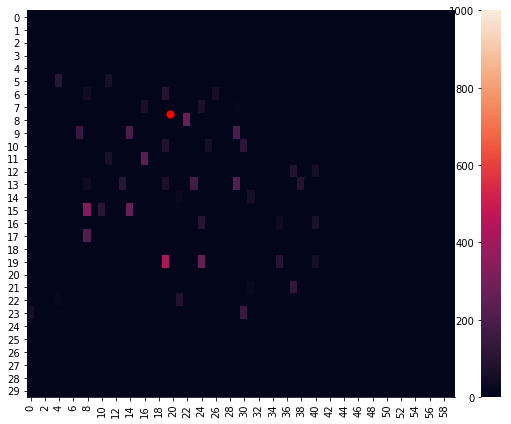

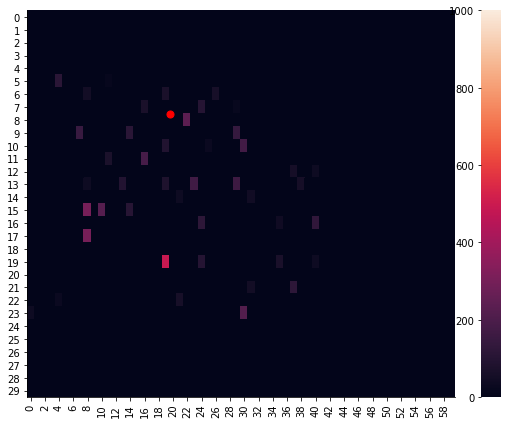

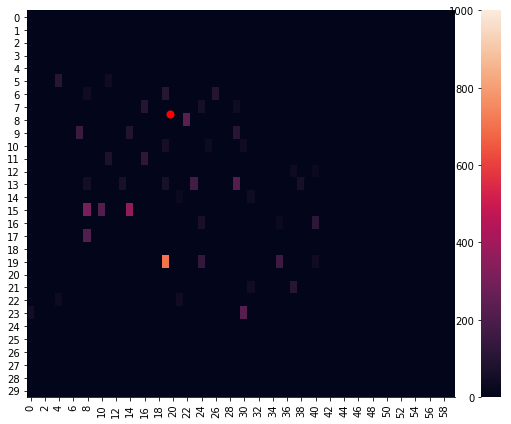

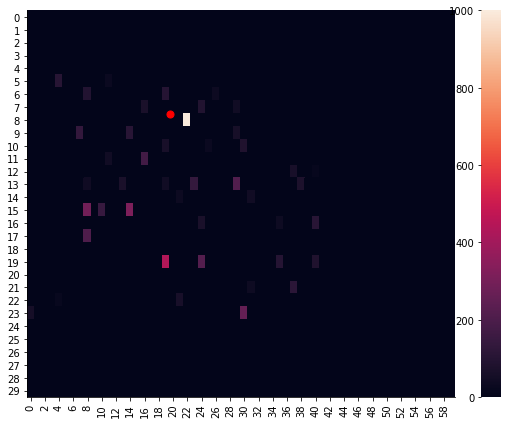

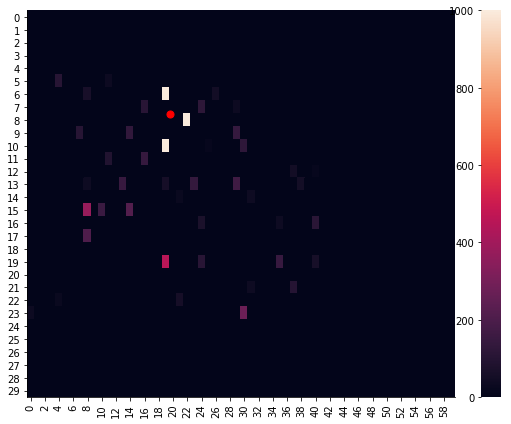

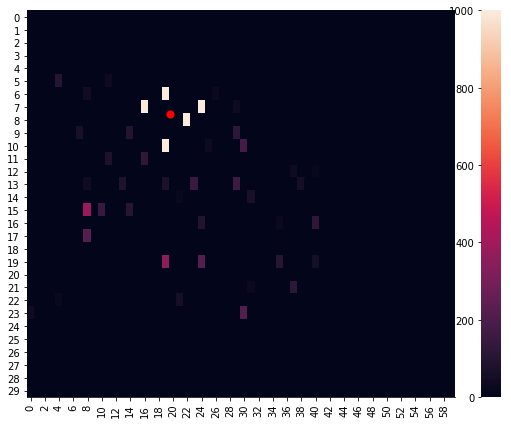

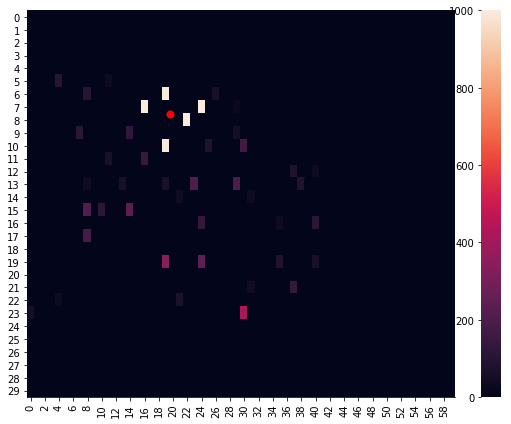

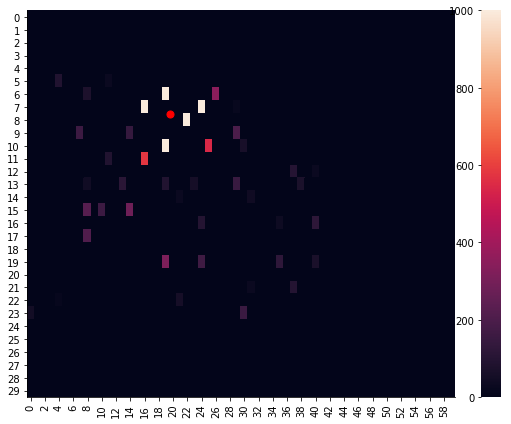

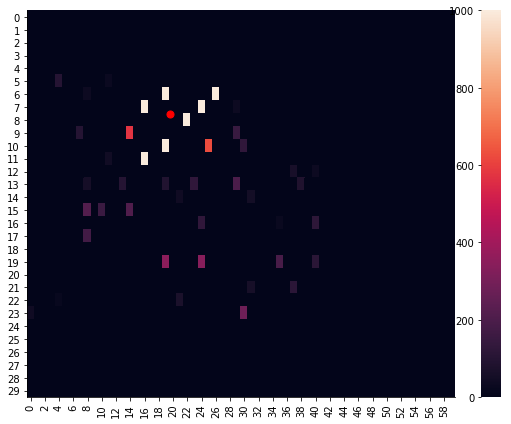

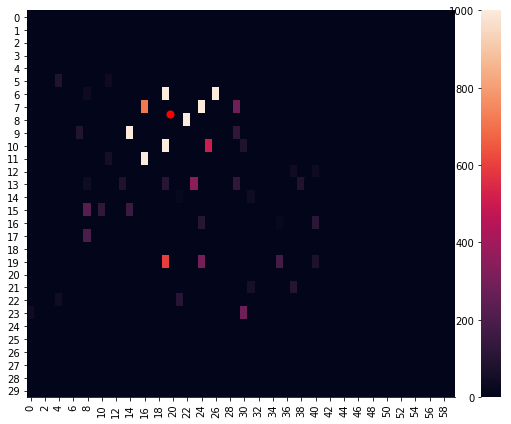

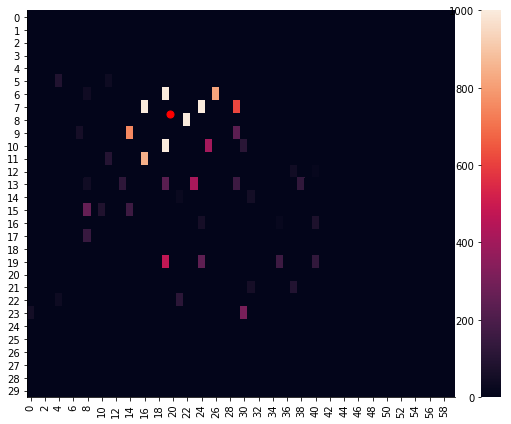

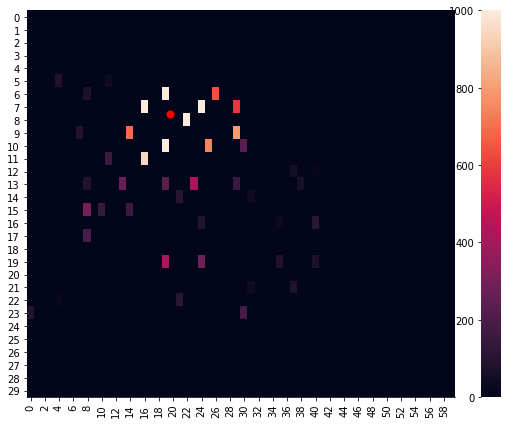

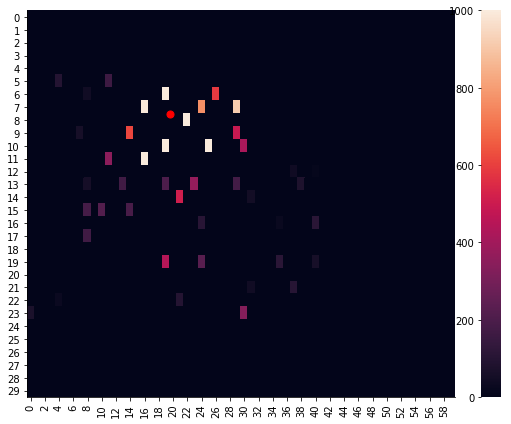

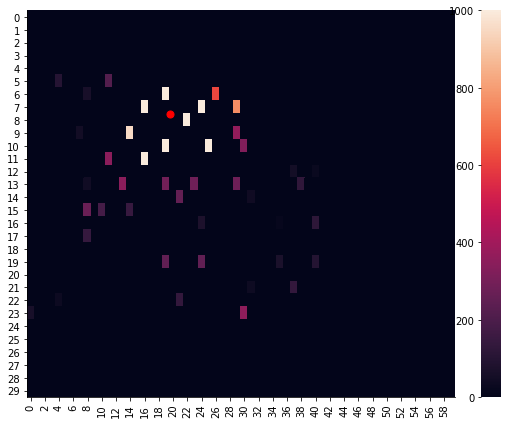

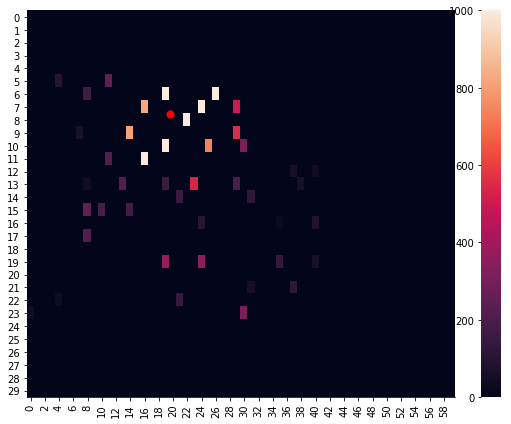

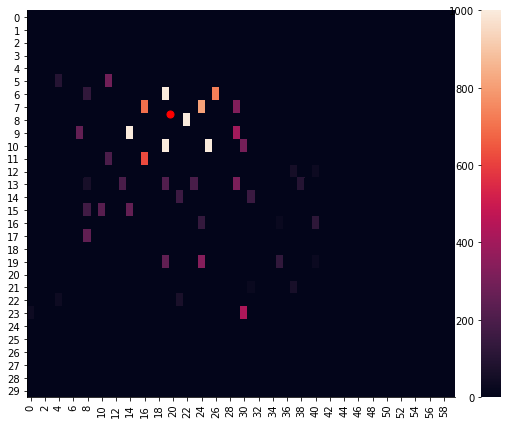

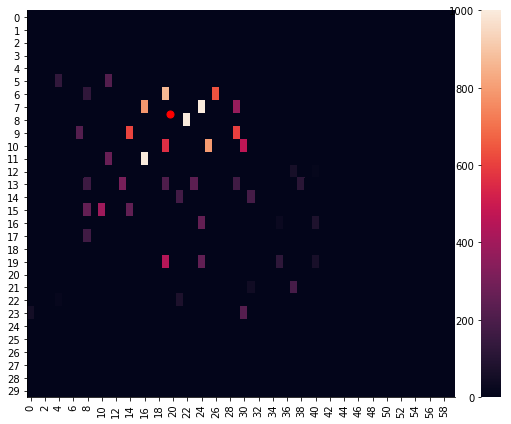

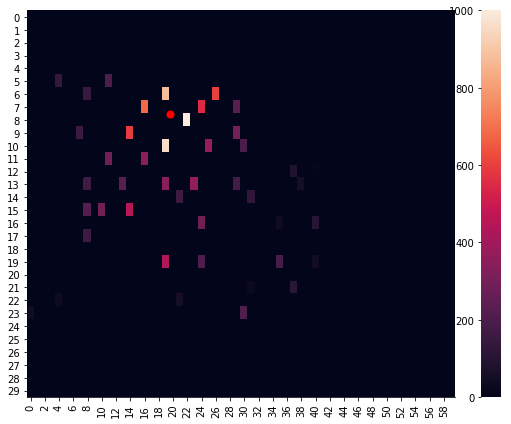

In [17]:
train, test = split_traintest(get_fnames(), 0.7)
justone = specificevent(get_fnames(), 'knmi2016ksik')#justoneevent(train)
with tf.Session() as sess:
    n = train_input_fn('data/tiles/metadata.json',justone)
    i, label = sess.run(n)
    print(label[0], np.shape(i['image']))
    for idx in range(20):
        sliced = i['image'][0,:,:,idx]
        plot_slice(sliced, label[0])

In [9]:
def main(labelmeta, train_fnames, test_fnames): 
    my_feature_columns = [tf.feature_column.numeric_column('image',shape=20*30*60)]
    # Build 2 hidden layer DNN with 100, 100 units respectively.
    classifier = tf.estimator.DNNRegressor(
        feature_columns=my_feature_columns,
        # The model must choose between 4 classes
        label_dimension=2,
        # Two hidden layers of 100 nodes each.
        hidden_units=[10],
        model_dir = 'tmp/small_tiles_debug',
        config=tf.estimator.RunConfig().replace(save_summary_steps=1)
        )
    # Train the Model.
    classifier.train(input_fn=lambda:train_input_fn(labelmeta,train_fnames,repeat=1000))

    # Evaluate the model.
    eval_result = classifier.evaluate(
        input_fn=lambda:test_input_fn(labelmeta, test_fnames))
    print([k for k in eval_result])
    #print('\nTest set accuracy: {accuracy:0.3f}\n'.format(**eval_result))
    predictions = classifier.predict(
        input_fn=lambda:test_input_fn(labelmeta, test_fnames))
    return classifier

In [10]:
train, test = split_traintest(get_fnames(), 0.7)
justone = specificevent(get_fnames(), 'knmi2017gpqn')
labelmeta = 'data/tiles/metadata.json'
c = main(labelmeta, justone, justone)

INFO:tensorflow:Using config: {'_keep_checkpoint_every_n_hours': 10000, '_save_summary_steps': 1, '_task_type': 'worker', '_tf_random_seed': None, '_task_id': 0, '_save_checkpoints_secs': 600, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f557d05e668>, '_num_worker_replicas': 1, '_session_config': None, '_model_dir': 'tmp/small_tiles_debug', '_is_chief': True, '_log_step_count_steps': 100, '_save_checkpoints_steps': None, '_keep_checkpoint_max': 5, '_master': '', '_num_ps_replicas': 0, '_service': None}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from tmp/small_tiles_debug/model.ckpt-1


InvalidArgumentError: tensor_name = dnn/hiddenlayer_0/kernel/t_0/Adagrad; shape in shape_and_slice spec [36000,10] does not match the shape stored in checkpoint: [18000,10]
	 [[Node: save/RestoreV2_3 = RestoreV2[dtypes=[DT_FLOAT], _device="/job:localhost/replica:0/task:0/device:CPU:0"](_arg_save/Const_0_0, save/RestoreV2_3/tensor_names, save/RestoreV2_3/shape_and_slices)]]

Caused by op 'save/RestoreV2_3', defined at:
  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/m13uz/groningen/venv/lib/python3.5/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/m13uz/groningen/venv/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/m13uz/groningen/venv/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/home/m13uz/groningen/venv/lib/python3.5/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/home/m13uz/groningen/venv/lib/python3.5/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/m13uz/groningen/venv/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/home/m13uz/groningen/venv/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/m13uz/groningen/venv/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/home/m13uz/groningen/venv/lib/python3.5/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/m13uz/groningen/venv/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/m13uz/groningen/venv/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/m13uz/groningen/venv/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/m13uz/groningen/venv/lib/python3.5/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/m13uz/groningen/venv/lib/python3.5/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/m13uz/groningen/venv/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2728, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/m13uz/groningen/venv/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2850, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/m13uz/groningen/venv/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-10-e804d0f21a22>", line 4, in <module>
    c = main(labelmeta, justone, justone)
  File "<ipython-input-9-0e481a5fc019>", line 14, in main
    classifier.train(input_fn=lambda:train_input_fn(labelmeta,train_fnames,repeat=1000))
  File "/home/m13uz/groningen/venv/lib/python3.5/site-packages/tensorflow/python/estimator/estimator.py", line 314, in train
    loss = self._train_model(input_fn, hooks, saving_listeners)
  File "/home/m13uz/groningen/venv/lib/python3.5/site-packages/tensorflow/python/estimator/estimator.py", line 812, in _train_model
    log_step_count_steps=self._config.log_step_count_steps) as mon_sess:
  File "/home/m13uz/groningen/venv/lib/python3.5/site-packages/tensorflow/python/training/monitored_session.py", line 380, in MonitoredTrainingSession
    stop_grace_period_secs=stop_grace_period_secs)
  File "/home/m13uz/groningen/venv/lib/python3.5/site-packages/tensorflow/python/training/monitored_session.py", line 787, in __init__
    stop_grace_period_secs=stop_grace_period_secs)
  File "/home/m13uz/groningen/venv/lib/python3.5/site-packages/tensorflow/python/training/monitored_session.py", line 511, in __init__
    self._sess = _RecoverableSession(self._coordinated_creator)
  File "/home/m13uz/groningen/venv/lib/python3.5/site-packages/tensorflow/python/training/monitored_session.py", line 972, in __init__
    _WrappedSession.__init__(self, self._create_session())
  File "/home/m13uz/groningen/venv/lib/python3.5/site-packages/tensorflow/python/training/monitored_session.py", line 977, in _create_session
    return self._sess_creator.create_session()
  File "/home/m13uz/groningen/venv/lib/python3.5/site-packages/tensorflow/python/training/monitored_session.py", line 668, in create_session
    self.tf_sess = self._session_creator.create_session()
  File "/home/m13uz/groningen/venv/lib/python3.5/site-packages/tensorflow/python/training/monitored_session.py", line 431, in create_session
    self._scaffold.finalize()
  File "/home/m13uz/groningen/venv/lib/python3.5/site-packages/tensorflow/python/training/monitored_session.py", line 212, in finalize
    self._saver.build()
  File "/home/m13uz/groningen/venv/lib/python3.5/site-packages/tensorflow/python/training/saver.py", line 1248, in build
    self._build(self._filename, build_save=True, build_restore=True)
  File "/home/m13uz/groningen/venv/lib/python3.5/site-packages/tensorflow/python/training/saver.py", line 1284, in _build
    build_save=build_save, build_restore=build_restore)
  File "/home/m13uz/groningen/venv/lib/python3.5/site-packages/tensorflow/python/training/saver.py", line 759, in _build_internal
    restore_sequentially, reshape)
  File "/home/m13uz/groningen/venv/lib/python3.5/site-packages/tensorflow/python/training/saver.py", line 471, in _AddShardedRestoreOps
    name="restore_shard"))
  File "/home/m13uz/groningen/venv/lib/python3.5/site-packages/tensorflow/python/training/saver.py", line 428, in _AddRestoreOps
    tensors = self.restore_op(filename_tensor, saveable, preferred_shard)
  File "/home/m13uz/groningen/venv/lib/python3.5/site-packages/tensorflow/python/training/saver.py", line 268, in restore_op
    [spec.tensor.dtype])[0])
  File "/home/m13uz/groningen/venv/lib/python3.5/site-packages/tensorflow/python/ops/gen_io_ops.py", line 1031, in restore_v2
    shape_and_slices=shape_and_slices, dtypes=dtypes, name=name)
  File "/home/m13uz/groningen/venv/lib/python3.5/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/home/m13uz/groningen/venv/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 3160, in create_op
    op_def=op_def)
  File "/home/m13uz/groningen/venv/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 1625, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

InvalidArgumentError (see above for traceback): tensor_name = dnn/hiddenlayer_0/kernel/t_0/Adagrad; shape in shape_and_slice spec [36000,10] does not match the shape stored in checkpoint: [18000,10]
	 [[Node: save/RestoreV2_3 = RestoreV2[dtypes=[DT_FLOAT], _device="/job:localhost/replica:0/task:0/device:CPU:0"](_arg_save/Const_0_0, save/RestoreV2_3/tensor_names, save/RestoreV2_3/shape_and_slices)]]


In [ ]:
predictions = c.predict(
        input_fn=lambda:test_input_fn(labelmeta, justone))

In [ ]:
pred = list(predictions)

In [ ]:
testeg= [i[1] for i in gen(labelmeta,10, justone)]


In [ ]:
predlabel = [i.get('predictions') for i in pred]
predlabel[0], testeg[0]

In [ ]:
fig,ax = plt.subplots(1)
s,f =(0,2000)
ax.scatter([i[0] for i in predlabel[s:f]], [i[1] for i in predlabel[s:f]], color ='b')
for one, two in list(zip(predlabel, testeg))[s:f]:
    ax.plot([one[0],two[0]], [one[1],two[1]], linestyle ='--', alpha=0.1)
ax.scatter([i[0] for i in testeg[s:f]], [i[1] for i in testeg[s:f]], color ='r', s=50)
sns.despine()
ax.set_xlim([0,60])
ax.set_ylim([0,30])